# CHAPTER 6 머신러닝을 이용한 투자 전략



*   금융 데이터를 분석하기 위해 어떤 방법으로 분석할지?
*   무엇을 근거로 상승세를 판단할 것이지에 대한 정의가 필요
*   이러한 정의를 내릴 떄는 실제 트레이딩 가능 여부를 고려, 많은 데이터 수집 필요, 수집된 데이터와 정의된 문제에 따라 알맞은 분석 방법론과 머신러닝 모델 선택
*   퀀트 전략이 정량적 분석에 기반하지만 결국 주관적인 인사이트를 바탕으로 만들어짐.
*   금융 투자에서 알고리즘은 당사자가 직접 머신러닝 테크닉을 배우고 그 지식과 경험을 토대로 인사이트를 발휘해 시장을 이기는 전략을 만드는 것









## 6.1 ETFs를 활용한 주가 방향 예측


*  ETFs 데이터와 거시경제 지표 데이터에 트리 기반 머신러닝 알고리즘을 적용한 투자 전략을 구현

    ※ ETF는 KOSPI200, KOSPI50과 같은 특정지수의 수익율을 얻을 수 있도록 설계된 지수연동형 펀드
*  A, B, C라는 3명의 트레이더를 가정


> A : 주가의 움직임을 중요하게 본다. 이동평균, RSI 등 주가 데이터로 생성된 기술 지표를 사용

> B : 소비자 물가, 금리 등 거시경제 지표에 기반해 투자


> C : 금, 달러 등 다양한 자산 간의 관계에 초점을 맞춰 트레이딩





*  이 트레이너들이 데이터를 학습하고 의견을 조합해 매매 시그널을 준다면? 머신러닝을 활용해서 이러한 작업이 가능
*   머신러닝도 데이터에 기반하지만, 데이터를 통해 사람이 직관적으로 발견하기 힘든 패턴을 찾아 시그널로 사용


*   단일 의사결정 트리 모델을 사용했을 때, 이동 평균 지수를 중점으로 볼 경우 : 이동 평균 지수가 특정 값을 넘으면 다음날 주식이 오를 가능성이 높다 생각하고, 다른 변수인 금 가격, 장단기 금리 차이등을 살펴보며 주식의 등락을 판단. -> 과적합 위험이 너무 크다.
*   랜덤포레스트는 여러개의 트리를 만들어, 즉 여러 트레이더를 만들고 이들의 의견을 조합하는 방식
*  이렇게 만들어진 트리가 숲이 되는 것이고 의견을 통합하는 방법 중 투표가 있는데 투표를 어떻게 해야할지도 알고리즘 모델링에서 결정해야할 요소, 이 의견들을 종합하거나 결과를 합치는 방식을 앙상블 메서드라고 함.
*  랜덤 포레스트 중 '랜덤'은 요소를 랜덤으로 선택한다는 의미 -> 최대한 많은 의견을 고려하기 위해서 무작위 방법을 쓴다고 생각하면 됨
*  부스팅 : 이전 트리의 오차를 보완하는 방식으로 순차적으로 트리를 만들어 랜덤포레스트보다 덜 독립적임.










 



### 6.1.1 데이터

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import glob
import os
import datetime
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.metrics import precision_score, recall_score, confusion_matrix, roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn import svm

import seaborn as sns; sns.set()

In [ ]:
!git clone https://https://github.com/quant4junior/algoTrade/git

Cloning into 'git'...
fatal: unable to access 'https://https://github.com/quant4junior/algoTrade/git/': Could not resolve host: https


In [ ]:
!ls

drive  sample_data


In [ ]:
cd ch06

In [ ]:
!ls

drive  sample_data


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/CHAPTER 6/ETFs_main.csv')

In [ ]:
df.head()

,Dates,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO
0,2007-02-20,146.04,145.56,146.20,144.0,56909500.0,65.31,83.51,2.3263,0.31,48.67,25.07,10.24,40.055
1,2007-02-21,145.98,145.61,146.07,145.0,63971500.0,67.28,82.90,2.3653,0.32,49.86,25.12,10.20,39.975
2,2007-02-22,145.87,146.05,146.42,145.0,79067398.0,67.15,82.46,2.3871,0.31,50.33,25.12,10.18,40.220
3,2007-02-23,145.30,145.74,145.79,145.0,71962797.0,67.72,82.78,2.3809,0.31,50.46,25.04,10.58,40.035
4,2007-02-26,145.17,145.83,145.95,145.0,69320062.0,68.10,83.08,2.3795,0.31,50.90,25.04,11.15,39.960


*   GLD : 금 ETF
*   FXY : FX트레이딩?
*   T10Y2Y : 미국 국채 10년-2년 차이
*   TED : 미국 국채 3개월 수익률과 리보 간의 차이
*   USO : 미국 유류 관련 펀드
*   UUP : 달러 인덱스
*   VIX : S&P 지수옵션의 30일간 변동성에 대한 시장기대, 높을수록 투자자 불안심리가 극에 달았다고 함. 공포지수라고도 불림
*   VOW : 이머징 마켓에 투자하는 ETF











In [ ]:
#기술적 지표 만들기
def moving_average(df, n):
    MA = pd.Series(df['CLOSE_SPY'].rolling(n, min_periods=n).mean(), name='MA_' + str(n))
    df = df.join(MA)
    return df

def volume_moving_average(df, n):
    VMA = pd.Series(df['VOLUME'].rolling(n, min_periods=n).mean(), name='VMA_' + str(n))
    df = df.join(VMA)
    return df

def relative_strength_index(df, n):
    """Calculate Relative Strength Index(RSI) for given data.
    
    :param df: pandas.DataFrame
    :param n: 
    :return: pandas.DataFrame
    """
    i = 0
    UpI = [0]
    DoI = [0]    
    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'HIGH'] - df.loc[i, 'HIGH']
        DoMove = df.loc[i, 'LOW'] - df.loc[i + 1, 'LOW']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(PosDI / (PosDI + NegDI), name='RSI_' + str(n))
    df = df.join(RSI)
    return df

기술지표는 각각 이동평균, 거래량 이동평균, 시장 강도 지수라는 세 가지 지표를 사용


In [ ]:
df = moving_average(df, 45)
df = volume_moving_average(df, 45)
df = relative_strength_index(df, 14)

In [ ]:
df

,Dates,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
0,2007-02-20,146.04,145.56,146.200,144.0,56909500.0,65.31,83.51,2.3263,0.31,48.67,25.07,10.24,40.055,NaN,NaN,NaN
1,2007-02-21,145.98,145.61,146.070,145.0,63971500.0,67.28,82.90,2.3653,0.32,49.86,25.12,10.20,39.975,NaN,NaN,NaN
2,2007-02-22,145.87,146.05,146.420,145.0,79067398.0,67.15,82.46,2.3871,0.31,50.33,25.12,10.18,40.220,NaN,NaN,NaN
3,2007-02-23,145.30,145.74,145.790,145.0,71962797.0,67.72,82.78,2.3809,0.31,50.46,25.04,10.58,40.035,NaN,NaN,NaN
4,2007-02-26,145.17,145.83,145.950,145.0,69320062.0,68.10,83.08,2.3795,0.31,50.90,25.04,11.15,39.960,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2766,2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.87,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439
2767,2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.87,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578
2768,2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.55,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,0.115003
2769,2018-12-27,248.07,242.57,248.290,239.0,186267297.0,120.57,86.00,1.7581,0.44,9.62,25.57,29.96,37.900,267.275778,1.297876e+08,0.307099


영업일 기준으로해서 45일로 작성, 시장 강도지수는 보통 14일이나 21일을 많이 사용한다고 함.

In [ ]:
df = df.set_index('Dates')

In [ ]:
df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,,,,,,
2007-02-20,146.04,145.56,146.200,144.0,56909500.0,65.31,83.51,2.3263,0.31,48.67,25.07,10.24,40.055,NaN,NaN,NaN
2007-02-21,145.98,145.61,146.070,145.0,63971500.0,67.28,82.90,2.3653,0.32,49.86,25.12,10.20,39.975,NaN,NaN,NaN
2007-02-22,145.87,146.05,146.420,145.0,79067398.0,67.15,82.46,2.3871,0.31,50.33,25.12,10.18,40.220,NaN,NaN,NaN
2007-02-23,145.30,145.74,145.790,145.0,71962797.0,67.72,82.78,2.3809,0.31,50.46,25.04,10.58,40.035,NaN,NaN,NaN
2007-02-26,145.17,145.83,145.950,145.0,69320062.0,68.10,83.08,2.3795,0.31,50.90,25.04,11.15,39.960,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.87,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.87,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578
2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.55,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,0.115003


Dates 열을 인덱스로 설정. 이동평균 지수를 만들면 사용한 일수만큼 NA가 생긴다. 왜냐면 오늘 날짜의 10일 이동 평균을 계산하려면 오늘 일자를 기준으로 10일 전부터 저장된 데이터를 사용해야 하므로 -> 결측치 처리 필수

결측치를 방지해주기 위해 쿠션데이터를 추가해줘라.
쿠션데이터는 예를들러 2017년 1월 이후 데이터를 훈련에 사용한다고 했을 때, 30일 이동 평균 지표를 쓴다고하면 2016년 12월 데이터도 확보해야 하는데 이를 쿠션데이터라고 함.

In [ ]:
df = df.dropna()

In [ ]:
df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,,,,,,
2007-04-27,149.53,149.09,149.740,149.0,106984094.0,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018
2007-04-30,148.29,149.64,149.740,148.0,100874203.0,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751
2007-05-02,149.54,148.90,149.950,149.0,87129805.0,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050
2007-05-03,150.35,149.97,150.400,149.0,87204945.0,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028
2007-05-04,150.92,150.75,151.120,150.0,96408930.0,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.8700,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578
2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.5500,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,0.115003


In [ ]:
len(df)

2727

데이터 총 2727건 

In [ ]:
df['target'] = df['CLOSE_SPY'].pct_change()

In [ ]:
df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14,target
Dates,,,,,,,,,,,,,,,,,
2007-04-27,149.53,149.09,149.740,149.0,106984094.0,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018,NaN
2007-04-30,148.29,149.64,149.740,148.0,100874203.0,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751,-0.008293
2007-05-02,149.54,148.90,149.950,149.0,87129805.0,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050,0.008429
2007-05-03,150.35,149.97,150.400,149.0,87204945.0,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028,0.005417
2007-05-04,150.92,150.75,151.120,150.0,96408930.0,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987,0.003791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439,-0.016278
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.8700,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578,-0.026176
2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.5500,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,0.115003,-0.026423


pct_change 함수를 이용해서 일별 수익률을 계산 

In [ ]:
df['target'].describe()

count    2726.000000
mean        0.000270
std         0.013026
min        -0.098448
25%        -0.004320
50%         0.000545
75%         0.005791
max         0.128249
Name: target, dtype: float64

In [ ]:
df['target'] = np.where(df['target'] > 0 , 1, -1)
df['target'].value_counts()

 1    1471
-1    1256
Name: target, dtype: int64

주가의 상승과 하락을 판단하기위해 수익률이 0보다 크면 1, 작으면 -1

일별 기준으로 오른날이 1471일 떨어진날이 1256일이라는 의미!

In [ ]:
df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14,target
Dates,,,,,,,,,,,,,,,,,
2007-04-27,149.53,149.09,149.740,149.0,106984094.0,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018,-1
2007-04-30,148.29,149.64,149.740,148.0,100874203.0,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751,-1
2007-05-02,149.54,148.90,149.950,149.0,87129805.0,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050,1
2007-05-03,150.35,149.97,150.400,149.0,87204945.0,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028,1
2007-05-04,150.92,150.75,151.120,150.0,96408930.0,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439,-1
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.8700,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578,-1
2018-12-24,234.34,239.04,240.836,234.0,147311594.0,120.02,86.5500,1.7505,0.40,9.29,25.55,36.07,37.320,267.995333,1.281067e+08,0.115003,-1


*   저자는 주가 트렌드 분류 모델의 예측력이 54~56% 만되어도 훌륭한 모델이라고 함. 
*   위 케이스의 경우 정확도를 지표로 훈련하게되면 그냥 오른다고만 찍어도 54%의 정확도를 갖는다는 말임. 따라서 최대한 균일한 트렌드를 갖도록 만들거나, 정확도가 아닌 학습 평가지표를 사용해야 함. 이를 각별히 주의 해야 함.






In [ ]:
df['target'] = df['target'].shift(-1)



*   당일까지의 데이터를 사용해 다음날을 예측하므로 shift 함수로 한 행 앞으로 당겨줌




In [ ]:
df = df.dropna()
df['target'] = df['target'].astype(np.int64)
y_var = df['target']
# 예측에 사용하지 않는 변수 삭제
x_var = df.drop(['target', 'OPEN','HIGH','LOW', 'VOLUME','CLOSE_SPY'], axis=1)



*   astype(np.int64) : target 변수에 소수점을 정수로 처리
*   drop 함수에서 axis=1은 컬럼, axis=0은 로우(디폴트)






In [ ]:
x_var.head()

,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14
Dates,,,,,,,,,,,
2007-04-27,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018
2007-04-30,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751
2007-05-02,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050
2007-05-03,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028
2007-05-04,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987


In [ ]:
df

,CLOSE_SPY,OPEN,HIGH,LOW,VOLUME,CLOSE_GLD,CLOSE_FXY,CLOSE_T10Y2Y,CLOSE_TED,CLOSE_USO,CLOSE_UUP,CLOSE_VIX,CLOSE_VWO,MA_45,VMA_45,RSI_14,target
Dates,,,,,,,,,,,,,,,,,
2007-04-27,149.53,149.09,149.740,149.0,106984094.0,67.56,83.7300,2.4474,0.55,51.84,24.54,12.45,41.750,143.551556,1.106696e+08,0.670018,-1
2007-04-30,148.29,149.64,149.740,148.0,100874203.0,67.09,83.7166,2.4361,0.57,51.24,24.49,14.22,40.935,143.601556,1.116466e+08,0.531751,1
2007-05-02,149.54,148.90,149.950,149.0,87129805.0,66.66,83.3800,2.4366,0.59,49.59,24.66,13.08,42.020,143.680667,1.121613e+08,0.554050,1
2007-05-03,150.35,149.97,150.400,149.0,87204945.0,67.49,83.1100,2.4346,0.60,49.28,24.69,13.09,42.435,143.780222,1.123421e+08,0.601028,1
2007-05-04,150.92,150.75,151.120,150.0,96408930.0,68.19,83.2300,2.4006,0.60,48.30,24.60,12.91,42.595,143.905111,1.128853e+08,0.665987,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19,251.26,255.17,259.400,249.0,214992797.0,117.43,84.8300,1.7824,0.44,10.02,25.97,25.58,37.890,270.407333,1.225288e+08,0.201733,-1
2018-12-20,247.17,249.86,251.620,245.0,252053406.0,119.24,85.8700,1.7807,0.48,9.72,25.77,28.38,38.180,269.767778,1.240592e+08,0.172439,-1
2018-12-21,240.70,246.74,249.710,240.0,255345594.0,118.72,85.8700,1.7651,0.48,9.57,25.94,30.11,37.870,269.018889,1.274610e+08,0.142578,-1


In [ ]:
up=df[df['target']==1].target.count()
up

1471

In [ ]:
total=df.target.count()
total

2726

In [ ]:
print('up/down ratio: {0:.2f}'.format((up/total)))

up/down ratio: 0.54


### 6.1.2 모델학습

*   훈련 셋과 테스트 셋을 나눈다. 이 때 기간이 섞이면 안되므로 shuffle 매개변수를 False로 준다.
*   항목 추가




In [ ]:
#훈련 세트와 테스트 세트를 나눈다.
#shuffle=False을 설정해 기간이 섞이지 않도록 만든다.
X_train, X_test, y_train, y_test = train_test_split(x_var, 
                                                    y_var, 
                                                    test_size=0.3, 
                                                    shuffle=False, 
                                                    random_state=3)

#훈련 세트와 테스트 세트에 포함된 양성 샘플(up) 비율을 확인한다.
train_count = y_train.count()
test_count = y_test.count()

print('train set label ratio')
print(y_train.value_counts()/train_count)
print('test set label ratio')
print(y_test.value_counts()/test_count)

train set label ratio
 1    0.543501
-1    0.456499
Name: target, dtype: float64
test set label ratio
 1    0.530562
-1    0.469438
Name: target, dtype: float64




*   훈련셋과 테스트셋의 주가 트렌드가 다를 수 있으니 count(), value_count() 함수를 써서 확인, 기간이 충분히 길면 큰 차이없으나 종목에 따라 다르니 주의 필요
*   위 경우 양성/ 음성 비율이 비슷하다는걸 확인.



In [ ]:
def get_confusion_matrix(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_score = roc_auc_score(y_test, pred)
    print('confusion matrix')
    print('accuracy:{0:.4f},precision:{1:.4f},recall:{2:.4f},F1:{3:.4f},ROC AUC score:{4:.4f}'.format(accuracy, precision, recall, f1,roc_score))

*   위 함수는 정확도, ROC-AUC 점수 등 혼동행렬을 계산하는 함수




In [ ]:
xgb_dis = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_dis.fit(X_train, y_train)
xgb_pred = xgb_dis.predict(X_test)

In [ ]:
xgb_dis

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

*   테스트를 위해 XGBoost 분류기를 뜻하는 XGBClassifier()을 사용. (매개변수는 임의)


In [ ]:
print(xgb_dis.score(X_train, y_train))

0.8763102725366876


In [ ]:
get_confusion_matrix(y_test, xgb_pred)

confusion matrix
accuracy:0.4914,precision:0.5242,recall:0.4493,F1:0.4839,ROC AUC score:0.4942


*   fit 함수에 훈련 데이터(X_train)과 훈련 레이블(y_train)을 넣음
(훈련 데이터는 문제집, 훈련 레이블은 답안지인 셈)


*  먼저 문제를 풀고 답을 보면서 진화해가는 것. 즉 설명 변수에 어떤 패턴이 보일 떄 모델은 정답이 1인지에 대해 학습
*  예를들어 전날 금 값이 높으면 다음날 주가가 떨어진다는 패턴이 뚜렷하게 나타난다면 패턴을 잡아낼 수 있지만, 지속해서 패턴이 일어날지 알 수 없으므로 테스트셋을 활용해 테스트해봐야 함.



### 6.1.3 머신러닝 모델을 활용한 결과 예측


*   훈련 모델이 얼마나 잘 예측하는지 Predict() 함수를 통해 X_test(테스트 데이터)를 넣어주고 xgb_pred에 예상값을 저장.
*   위 87.6%의 정확도를 바탕으로 말하자면 훈련 데이터로 내일 주식의 등락을 87.6%로 맞힌다는 뜻
*  하지만 이 모델은 학습과정을 반복하면서 익일 주가의 상승에 대해 설명 변수들을 조합한 패턴을 학습하지않고, 단순히 답을 외워버렸을 수도있기에 쓸모 없다.
*  get_confusion_matrix 함수에 의해 정확도를 찍어보니 49.1%가 나옴. 그냥 매일 오른다고 찍었을 경우(54%) 보다 낮음.. 이것이 바로 과적합 문제 때문임. (만약 max_depth 매개변수를 더 크게 만들면 더 큰 과적합이 생겨 정확도가 100%까지 나와버리는 일도 생김)
*   이를 통해 과적합이 왜 위험한지 알아볼 수 있었다.





In [ ]:
n_estimators = range(10,200,10)

params = {
    'bootstrap': [True],
    'n_estimators':n_estimators,
    'max_depth':[4,6,8,10,12],
    'min_samples_leaf': [2, 3, 4, 5],
    'min_samples_split': [2, 4, 6, 8, 10],
    'max_features':[4]
}

*   랜덤 포레스트 알고리즘을 이용하는데, 임의의 매개변수를 지정하는게 아니라 GridSearchCV() 함수를 사용(여러가지 값을 돌아가면서 테스트 해주는 기능, 최적의 파라메터도 찾아주고 교차검증도 해줌!)

*  트리들은 완전히 독립적이므로 무작위한 값을 선택하게 된다. 트리를 만들기 위해 부트스트랩 샘플을 생성하는데 n_samples개의 데이터 포인터 중 무작위로 데이터를 n_samples 횟수만큼 반복 추출
*   bootstrap : Ture(디폴드), sampling할때 중복 허용
*   각 노드에서 후보 특성을 랜덤하게 선택한 후 이 후보들 중 최선의 테스트를 찾는다 -> max_features 로 조정 가능
(결국 max_features 값을 크게 하면 랜덤 포레스트의 트리들은 매우 비슷해지고 가장 두드러진 특성을 이용해 데이터에 잘맞춰짐. max_features를 낮추면 랜덤 포레스트 트리들은 많이 달라지고 각 트리는 데이터에 맞추기 위해 깊이가 깊어짐)


In [ ]:
my_cv = TimeSeriesSplit(n_splits=5).split(X_train)

In [ ]:
my_cv

<generator object TimeSeriesSplit.split at 0x7f8b300bba98>

In [ ]:
clf = GridSearchCV(RandomForestClassifier(), params, cv=my_cv, n_jobs=-1)
clf.fit(X_train, y_train)

KeyboardInterrupt: ignored

In [ ]:
print('best parameter:\n', clf.best_params_)
print('best prediction:{0:.4f}'.format(clf.best_score_))



*   정확도가 



In [ ]:
pred_con = clf.predict(X_test)
accuracy_con = accuracy_score(y_test, pred_con)
print('accuracy:{0:.4f}'.format(accuracy_con))
get_confusion_matrix(y_test, pred_con)


*  predict()함수를 통해 X_test상에서의 정확도를 측정.
*  정확도가 생각보다 낮다. 걍 오른다고 찍는것만도 못함..
*  변수에 설명력이 없거나, 데이터 노이즈가 많은 탓일 수도있으나 등락을 판단하기가 모호하다면?
* 0.01% 상승과 10% 상승이 같은 것을 의미하는지 생각해봐야 함 -> 이를 통해 0.001% 같은 미세한 움직임은 다 버리고 큰 폭으로 오르는 트렌드만 잡고 훈련필요.
*  상승률을 바꿔서 테스트 해볼 필요가 있음(0.0005)
*  바꿔서 했더니 GridSearchCV 정확도가 53.27% 까지 올라갔고 테스트 정확도도 53.55%로 더 안정적


*   쓰레기가 들어가면 쓰레기가 나온다.
*   우수한 성능을 위해서는 더 많은 인사이트 필요, 더 많은 실험 필요
*  모델링에 도움이될 하이퍼파라미터들을 정리 220p~221p



### 6.1.4 확장 가능한 방법

*   위 문제에 대해 다중 분류 문제로 바꿔 볼것, 즉 상승 하락 뿐만 아니라 보합, 3% 이상 상승, 3% 이상 하락 등 다양한 시나리오 추가
*   머신러닝 알고리즘을 바꿔볼 것
*   변수를 바꿔볼 것.
*   예측하려는 종목/ 자산을 바꿔볼 것.
*   노이즈 제거 방법을 적용할 것.



## 6.2 K- 최근접 이웃 알고리즘을 활용한 투자 전략


*   K-nearest neighbor(KNN)은 유한한 특성을 가진 데이터 사이의 거리는 가깝다는 가정에서 출발
*   그림 6-3 참고, ★이 k값에 따라 어떤 그룹에 속할지에 대한 내용
*   KNN은 어떤 분포도 가정하지 않기때문에 비모수적 방법에 속함. 즉 데이터 개수가 많아야 효과적이므로 데이터를 대량 확보해야함.
*   직관적이고 간단하고 일관성있는 결과를 도출하므로 현업에서 자주 사용, 하지만 변수가 많을 수록 연산 비용이 높아지고 k에 대한 척도 설정을 잘해야 한다는 단점. 
*  변수 스케일 차이가 크면 반드시 정규화 필요


### 6.2.1 데이터


In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

from pandas_datareader import data as pdr #Yahoo Finance으로부터 데이터를 불러오기 위한 패키지

In [ ]:
df = pdr.get_data_yahoo('SPY','2012-01-01','2017-01-01')

In [ ]:
df = df.dropna()
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,128.380005,127.430000,127.760002,127.500000,193697900.0,107.134926
2012-01-04,127.809998,126.709999,127.199997,127.699997,127186500.0,107.302979
2012-01-05,128.229996,126.430000,127.010002,128.039993,173895000.0,107.588661
2012-01-06,128.220001,127.290001,128.199997,127.709999,148050000.0,107.311371
2012-01-09,128.179993,127.410004,128.000000,128.020004,99530200.0,107.571877


*  야후 파이낸스를 통해 데이터를 SPY etf를 가져옴.

In [ ]:
tmp_df = df[['Open','High','Low','Close']].copy()
tmp_df.head()

,Open,High,Low,Close
Date,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000
2012-01-04,127.199997,127.809998,126.709999,127.699997
2012-01-05,127.010002,128.229996,126.430000,128.039993
2012-01-06,128.199997,128.220001,127.290001,127.709999
2012-01-09,128.000000,128.179993,127.410004,128.020004


*   필요한 정보만 불러와 tmp_df에 저장

In [ ]:
tmp_df['Open-Close'] = tmp_df['Open'] - tmp_df['Close']
tmp_df['High-Low'] = tmp_df['High'] - tmp_df['Low']
tmp_df = tmp_df.dropna()
X = tmp_df[['Open-Close','High-Low']]
Y = np.where(tmp_df['Close'].shift(-1) > tmp_df['Open'].shift(-1), 1, -1)

*   Open : 시가
*   Close : 종가
*   High : 고가
*   Low : 저가
*   Y : 주가의 오르내림을 정의하는 레이블

다음날의 종가(tmp_df['Close'].shift(-1))가 다음날의 시가(tmp_df['Open'].shift(-1)) 보다 크다면 1, 아니면 -1

-> 오늘의 종가와 다음날 종가를 비교해서 오름을 정의하지 않고 이런 방식으로 하는 이유 :  오늘 종가가 이미 나온 시점에서 매수할 수 없으므로  다음날의 종가가 다음날의 시가보다 높으면 오른다고 정의 (다음날 시가에 사면 되니까)


In [ ]:
X

,Open-Close,High-Low
Date,,
2012-01-03,0.260002,0.950005
2012-01-04,-0.500000,1.099998
2012-01-05,-1.029991,1.799995
2012-01-06,0.489998,0.930000
2012-01-09,-0.020004,0.769989
...,...,...
2016-12-23,-0.280014,0.509995
2016-12-27,-0.250000,0.729996
2016-12-28,2.170013,2.319992


In [ ]:
tmp_df

,Open,High,Low,Close,Open-Close,High-Low
Date,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,0.260002,0.950005
2012-01-04,127.199997,127.809998,126.709999,127.699997,-0.500000,1.099998
2012-01-05,127.010002,128.229996,126.430000,128.039993,-1.029991,1.799995
2012-01-06,128.199997,128.220001,127.290001,127.709999,0.489998,0.930000
2012-01-09,128.000000,128.179993,127.410004,128.020004,-0.020004,0.769989
...,...,...,...,...,...,...
2016-12-23,225.429993,225.720001,225.210007,225.710007,-0.280014,0.509995
2016-12-27,226.020004,226.729996,226.000000,226.270004,-0.250000,0.729996
2016-12-28,226.570007,226.589996,224.270004,224.399994,2.170013,2.319992


### 6.2.2모델 학습

*   학습 데이터와 테스트 데이터를 분할
*   시계열 분석에서는 순서가 섞이면 안된다.
*   7:3 비율로 훈련셋과 테스트셋으로 나눔

In [ ]:
# 학습 데이터와 테스트 데이터를 분할한다
split_ratio = 0.7
split = int(split_ratio* len(tmp_df))
X_train = X[:split]
Y_train = Y[:split]

X_test = X[split:]
Y_test = Y[split:]

*   그래프를 그리기 위해 빈 리스트를 만든다. 반복문과 사이킷런의 KNeighbors Classifier() 함수를 사용해 모델 훈련
*   여기서 n은 k의 개수를 뜻한다.
*   이렇게 훈련 점수와 예측 점수를 계속해서 빈 리스트에 append 한다.


In [ ]:
#for 반복문을 통해 1~15까지의 k값을 가진 모델을 만들어 본다
train_acc = []
test_acc = []

for n in range(1,15):
    clf = KNeighborsClassifier(n_jobs=-1, n_neighbors=n)
    clf.fit(X_train, Y_train)
    prediction = clf.predict(X_test)
    train_acc.append(clf.score(X_train, Y_train))
    test_acc.append((prediction==Y_test).mean())

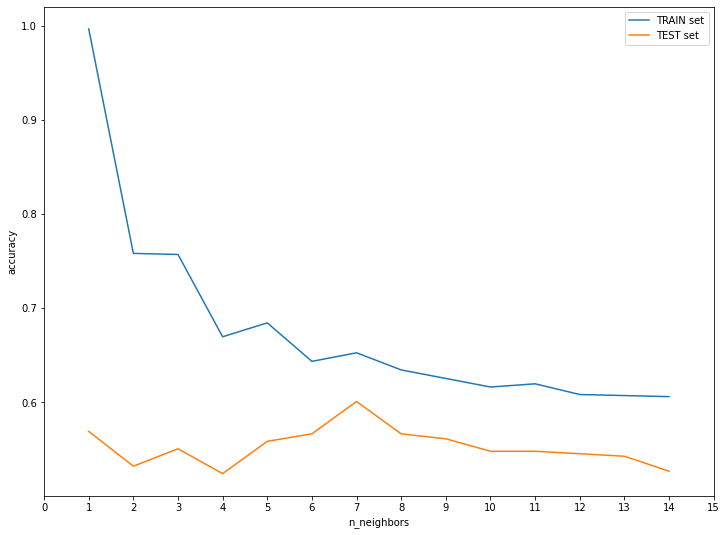

In [ ]:
# 위에서 만든 결과를 그래프로 만들어 준다
plt.figure(figsize=(12, 9))
plt.plot(range(1, 15), train_acc, label='TRAIN set')
plt.plot(range(1, 15), test_acc, label='TEST set')
plt.xlabel("n_neighbors")
plt.ylabel("accuracy")
plt.xticks(np.arange(0, 16, step=1))
plt.legend()



*   K가 1일 떄는 훈련데이터가 모든 패턴을 외워버려 100%의 정확도가 나옴
하지만 테스트 데이터는 성능이 저조함 -> 과적합 현상
*   테스트셋에서 k가 7일 때 정확도가 가낭 높고 머신러닝에서 얻고자 하는 모델은 테스트셋에서 좋은 성능을 발휘하는 모델이므로 7을 선택!



In [ ]:
knn = KNeighborsClassifier(n_neighbors = 7)

knn.fit(X_train,Y_train)

accuracy_train = accuracy_score(Y_train, knn.predict(X_train))
accuracy_test = accuracy_score(Y_test, knn.predict(X_test))

print('훈련 정확도 : %.2f' % accuracy_train)
print('테스트 정확도 : %.2f' % accuracy_test)

훈련 정확도 : 0.65
테스트 정확도 : 0.60


In [ ]:
tmp_df['Predicted_Signal'] = knn.predict(X)

tmp_df['SPY_ret'] = np.log(tmp_df['Close'] / tmp_df['Open'])
cum_spy_ret = tmp_df[split:]['SPY_ret'].cumsum() * 100

tmp_df['strategy_ret'] = tmp_df['SPY_ret'] * tmp_df['Predicted_Signal'].shift(1)
cum_st_ret = tmp_df[split:]['strategy_ret'].cumsum() * 100


In [ ]:
cum_spy_ret

Date
2015-07-06     0.460617
2015-07-07     0.971484
2015-07-08     0.051658
2015-07-09    -0.987337
2015-07-10    -0.895719
                ...    
2016-12-23    16.029079
2016-12-27    16.139627
2016-12-28    15.177244
2016-12-29    15.119320
2016-12-30    14.583917
Name: SPY_ret, Length: 378, dtype: float64

In [ ]:
cum_st_ret

Date
2015-07-06     0.460617
2015-07-07     0.971484
2015-07-08     0.051658
2015-07-09     1.090654
2015-07-10     0.999035
                ...    
2016-12-23    35.896941
2016-12-27    36.007490
2016-12-28    35.045107
2016-12-29    35.103030
2016-12-30    34.567627
Name: strategy_ret, Length: 378, dtype: float64

*   np.log는 자연로그, cumsum()은 누적합
*   위에 대한 부분은 책에 설명이 없음.. 로그를 취하는건 상대적 상승률을 구하기 위한 것같음..
(https://layhope.tistory.com/541) 참조
*   항목 추가



In [ ]:
tmp_df

,Open,High,Low,Close,Open-Close,High-Low,Predicted_Signal,SPY_ret,strategy_ret
Date,,,,,,,,,
2012-01-03,127.760002,128.380005,127.430000,127.500000,0.260002,0.950005,1,-0.002037,NaN
2012-01-04,127.199997,127.809998,126.709999,127.699997,-0.500000,1.099998,1,0.003923,0.003923
2012-01-05,127.010002,128.229996,126.430000,128.039993,-1.029991,1.799995,-1,0.008077,0.008077
2012-01-06,128.199997,128.220001,127.290001,127.709999,0.489998,0.930000,1,-0.003829,0.003829
2012-01-09,128.000000,128.179993,127.410004,128.020004,-0.020004,0.769989,1,0.000156,0.000156
...,...,...,...,...,...,...,...,...,...
2016-12-23,225.429993,225.720001,225.210007,225.710007,-0.280014,0.509995,1,0.001241,0.001241
2016-12-27,226.020004,226.729996,226.000000,226.270004,-0.250000,0.729996,1,0.001105,0.001105
2016-12-28,226.570007,226.589996,224.270004,224.399994,2.170013,2.319992,-1,-0.009624,-0.009624


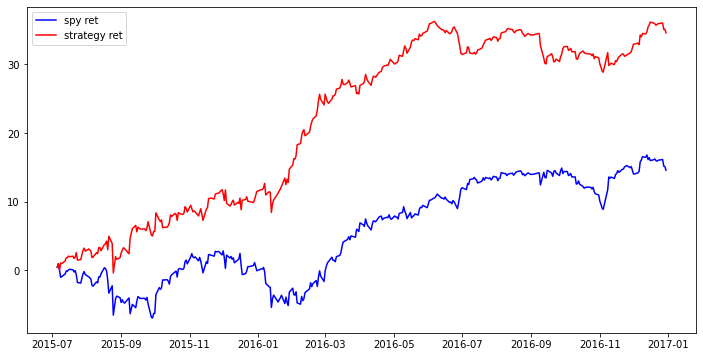

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(cum_spy_ret, color='b',label='spy ret')
plt.plot(cum_st_ret , color='r', label='strategy ret')
plt.legend()
plt.show()

*   테스트 기간동안 바이앤홀드 전략을 구사햇을 경우와 시그널에 따라 매매 했을 경우 수익률 그래프

바이앤홀드 : 저가라고 판단될 때 매수, 장기가 보유하다가 충분히 올랐을 때 매도

In [ ]:
print('TOTAL : ',tmp_df['Predicted_Signal'].count())
print('UP predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == 1,['Predicted_Signal']].count()[0])
print('DOWN predict : ',tmp_df.loc[tmp_df['Predicted_Signal'] == -1,['Predicted_Signal']].count()[0])

TOTAL :  1258
UP predict :  779
DOWN predict :  479


In [ ]:
test = tmp_df[split:]['SPY_ret']
test.cumsum()

Date
2015-07-06    0.004606
2015-07-07    0.009715
2015-07-08    0.000517
2015-07-09   -0.009873
2015-07-10   -0.008957
                ...   
2016-12-23    0.160291
2016-12-27    0.161396
2016-12-28    0.151772
2016-12-29    0.151193
2016-12-30    0.145839
Name: SPY_ret, Length: 378, dtype: float64

In [ ]:
std = cum_st_ret.std()
sharpe = (cum_st_ret - cum_spy_ret) / std
sharpe = sharpe.mean()
print('Sharpe ratio : %.2f' % sharpe)

Sharpe ratio : 1.30


*   샤프지수 1.3으로 높은 편, 좋은 전략같지만 단일 전략으로 사용하기엔 위험
*   훈련기간과 테스트 기간이 짧은 것이 문제의 소지, 테스트 데이터에 추세나 계절성이 있다면 KNN은 포착하기 어렵다.
* 따라서 데이터 검증을 통해 추세나 계절성을 분해 한다면 더 좋은결과를 낼 것.

##6.3 클러스터링 알고리즘을 활용한 종목 분류

*   무엇을 갖고 금융 데이터를 군집화 할까?
*   일정한 기준에 따라 자산 종목을 군집화가 필요
*   군집화란 ? x에대한 레이블이 지정 되어있지 않은 데이터를 그룹핑하는 분석 알고리즘, 데이터들의 특성을 고려해 데이터 집단(클러스터)을 정의하고 데이터 집단의 대표할 수 있는 중심점을 찾는 것으로 데이터 마이닝의 한 방법이다.
*  클러스터란 비슷한 특성을 가진 데이터들의 집단이다. 반대로 데이터의 특성이 다르면 다른 클러스터에 속해야 한다. 



In [1]:
import pandas as pd
import pandas_datareader as dr
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns


In [2]:
#Wikipeda에서 S&P500에 포함된 회사들의 리스트를 가져온다
sp500_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
data_table = pd.read_html(sp500_url)
tickers = data_table[0]['Symbol'].tolist()  #TICKER명만 리스트로 만든다.
security = data_table[0]['Security'].tolist() #Ticker명에 해당하는 회사 전체 이름을 리스트로 가져온다 (이해를 돕기 위한 작업이므로 건너뛰어도 무방하다)
sector = data_table[0]['GICS Sector'].tolist()

tickers = tickers[0:60] #이해를 돕기위해 적은 양의 데이터만 사용하도록 하겠다.
security = security[0:60]
sector = sector[0:60]

prices_list = []


* wikipedia에서 s&p 500 리스트가 담긴 url을 읽어옴  
* Symbol열만 선택해 리스트를 만든다.
* 이중 60개만 임의로 선택함.



In [3]:
#리스트 길이가 같은지 확인한다. equal 함수를 사용해도 되지만, 데이터가 복잡하지 않기 때문에 가장 간단한 방법을 사용했다.
print(len(tickers))
print(len(security))
print(len(sector))

60
60
60


*  tickers에는 회사의 간략한 심볼이름
*  security에는 회사이름 
*  sector에는 회사의 업종(제조업, 약품업 등등 )

In [4]:
#데이터 불러오기. 2017년1월1일 부터 2020년 2월 28일까지의 데이터를 가져온다.
for ticker in tickers:
    try:
        prices = dr.DataReader(ticker,'yahoo','01/01/2017')['Adj Close']
        prices = pd.DataFrame(prices)
        prices.columns = [ticker]
        prices_list.append(prices)
    except:
        pass
    prices_df = pd.concat(prices_list,axis=1)

prices_df.sort_index(inplace=True)

prices_df.head()

,MMM,ABT,ABBV,ABMD,ACN,ATVI,ADBE,AMD,AAP,AES,AFL,A,APD,AKAM,ALK,ALB,ARE,ALXN,ALGN,ALLE,LNT,ALL,GOOGL,GOOG,MO,AMZN,AMCR,AEE,AAL,AEP,AXP,AIG,AMT,AWK,AMP,ABC,AME,AMGN,APH,ADI,ANSS,ANTM,AON,AOS,APA,AIV,AAPL,AMAT,APTV,ADM,ANET,AJG,AIZ,T,ATO,ADSK,ADP,AZO,AVB,AVY
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-01-03,158.059586,36.294086,51.220478,112.360001,108.988495,35.706703,103.480003,11.43,168.355179,9.925014,31.761858,44.974556,130.081467,67.570000,82.422668,82.974663,99.341476,122.629997,96.959999,62.311558,33.607250,68.625214,808.010010,786.140015,54.181988,753.669983,8.902034,47.134960,44.741226,54.834415,70.771912,58.563797,98.723618,67.056870,100.940514,76.909164,47.975719,134.517654,65.012932,67.051659,93.349998,136.548782,107.331268,44.584717,58.016815,36.387016,27.277639,30.096201,54.445522,40.647903,97.059998,47.790226,86.198578,34.061092,68.299728,76.180000,95.367126,791.460022,155.646103,64.911896
2017-01-04,158.299225,36.582207,51.942707,115.739998,109.250534,36.408356,104.139999,11.43,169.736740,9.839895,32.053204,45.564671,131.215408,68.330002,83.527878,85.471878,101.856895,127.110001,97.769997,63.496151,33.811047,68.810257,807.770020,786.900024,54.358234,757.179993,8.902034,47.188942,45.127758,54.913052,71.932106,59.328209,98.900322,67.576630,103.963776,78.817696,48.550804,136.427490,65.494987,66.912941,94.440002,136.367630,108.509163,44.978928,57.843994,36.727089,27.247108,30.378887,56.460831,40.577499,101.730003,48.394012,87.086922,33.863155,68.684532,77.519997,95.514565,793.039978,156.289459,66.762833
2017-01-05,157.757690,36.898209,52.336643,114.809998,107.612801,36.973591,105.910004,11.24,169.618347,9.712214,31.843801,45.022934,129.918198,69.550003,82.197876,85.179764,101.488571,139.179993,94.820000,63.842850,33.766735,68.495667,813.020020,794.020020,54.422337,780.450012,8.902034,47.422916,44.345032,55.210117,71.045456,58.995457,98.556213,67.688004,102.646172,77.905327,47.936733,136.525650,65.147896,65.951233,94.709999,137.816635,108.671959,44.772442,57.534714,36.799953,27.385668,30.246964,56.114193,40.278290,101.940002,48.503780,87.123550,33.768147,68.345535,76.930000,94.943260,792.000000,157.241165,66.105736
2017-01-06,158.219330,37.901989,52.353065,115.419998,108.838760,36.944351,108.300003,11.32,167.397919,10.061208,31.953058,46.425671,130.952286,69.790001,81.467323,85.575554,100.805809,143.610001,94.080002,63.457638,33.492062,68.606712,825.210022,806.150024,54.662682,795.989990,8.902034,47.782860,44.654255,55.166431,71.186943,60.083630,97.905167,67.604454,104.378906,78.948051,48.804226,139.916946,65.639633,66.210159,93.949997,137.606918,109.505081,44.791218,57.416454,36.799953,27.690971,30.190432,55.759495,39.354282,101.279999,48.613564,87.902039,33.095348,67.951599,79.300003,95.007774,792.909973,158.624756,67.003456
2017-01-09,157.367111,37.864819,52.697758,117.110001,107.622154,36.739704,108.570000,11.49,167.299271,9.814359,31.648048,46.570778,132.721237,70.000000,81.926270,85.264565,99.763718,144.770004,94.790001,63.004963,33.031330,67.625946,827.179993,806.650024,54.438347,796.919983,8.902034,46.784016,45.494972,54.441254,71.554817,59.696926,97.672668,66.221573,103.963776,79.581116,48.375351,141.755325,64.964714,66.524574,94.290001,136.119781,108.595352,44.490856,56.725128,36.403214,27.944603,30.887709,54.864704,39.380680,99.519997,47.936604,86.189407,32.678848,67.072067,79.589996,94.418060,790.340027,156.174850,67.151520


*  for문 돌면서 야후 파이낸스를 통해 종목별 종가를 가져옴: DataReader() 함수 이용

In [6]:
df = prices_df.pct_change().iloc[1:].T

*  pct_change 함수로 수익률 계산
*  티커명을 인덱스로 바꿈

In [7]:
df.head()

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27,2020-11-30,2020-12-01
MMM,0.001516,-0.003421,0.002926,-0.005386,-0.003892,0.007418,-0.002529,-0.000282,-0.000733,0.006939,0.001064,-0.001063,0.000112,-0.014229,0.004319,0.000509,0.003733,-0.011607,-0.003420,0.002002,-0.005651,0.004937,0.000343,0.003769,0.007453,0.006269,0.004602,0.011285,0.003204,0.007067,0.009411,-0.002508,0.002296,0.014561,0.006182,0.001175,-0.002668,-0.002996,0.018835,0.000158,...,-0.003195,0.026259,0.007328,0.009481,-0.003839,-0.011977,0.010622,0.004038,0.011178,-0.008306,0.008257,-0.010412,0.009103,-0.005331,-0.021437,-0.030874,-0.015525,-0.000315,0.009339,0.018630,0.015773,-0.032324,0.018981,-0.001103,0.002515,0.034939,0.000414,-0.012765,0.016402,0.023971,-0.001265,-0.012900,0.009886,0.007459,0.007230,0.016883,0.000226,-0.001299,-0.023517,-0.012794
ABT,0.007938,0.008638,0.027204,-0.000981,0.013500,0.001341,-0.008763,0.005157,-0.000733,-0.003423,-0.008832,0.001485,-0.002966,-0.000744,0.000000,0.016125,0.000976,0.000244,0.018532,0.013407,0.009922,0.000702,-0.008181,0.010841,-0.011424,0.003302,0.004701,0.011231,0.009949,0.008018,0.004546,0.011086,0.007160,0.000000,0.008665,0.006167,-0.004816,-0.008359,0.011313,0.002193,...,-0.021279,0.014023,0.007425,0.010227,0.012768,-0.024133,-0.002407,-0.003991,0.021897,-0.014863,0.002962,-0.022425,0.033513,-0.015437,0.011226,-0.003853,-0.019893,-0.013343,0.001048,0.022548,0.019352,0.017981,0.017932,0.007839,-0.043961,0.012981,0.016605,-0.006214,0.005806,0.009503,-0.005366,-0.029100,0.011205,-0.000991,-0.014609,-0.015192,-0.011151,0.011371,0.005575,0.002495
ABBV,0.014100,0.007584,0.000314,0.006584,-0.002180,-0.036103,0.002290,0.011586,-0.002097,-0.003233,-0.004541,-0.003747,-0.003107,-0.006233,0.013206,-0.001792,-0.020728,0.007167,0.011253,-0.003600,0.000000,-0.003613,-0.000330,-0.001484,-0.000661,0.005288,-0.006903,0.001489,0.005123,0.013647,-0.002757,0.004717,0.000971,-0.007602,0.009453,0.002421,0.002094,-0.006107,0.016009,0.006685,...,-0.023200,0.013739,0.003101,0.004122,0.007070,-0.005548,-0.006694,-0.009759,0.012202,-0.022719,-0.000712,-0.016142,0.017131,0.000356,-0.004980,-0.014418,-0.026841,0.002236,0.054915,0.037015,-0.003286,0.074352,-0.008571,-0.008966,0.024448,0.039424,-0.007282,-0.005604,0.014754,-0.006866,0.008642,-0.004939,0.009623,0.011739,0.013288,0.017420,0.002309,0.006622,-0.002955,-0.005164
ABMD,0.030082,-0.008035,0.005313,0.014642,-0.041585,-0.008642,0.009886,0.029367,-0.014265,-0.006578,-0.009358,-0.003297,-0.002414,0.006543,0.022440,-0.076032,0.026016,-0.024805,0.002073,-0.007333,-0.014111,0.008261,0.052782,-0.005068,-0.011006,-0.002575,0.001752,-0.011598,0.014714,0.015235,0.032815,0.020306,0.010637,-0.006875,-0.000940,0.002139,0.006829,0.000254,0.028143,-0.010223,...,-0.021685,0.014047,0.009905,0.008702,0.015682,-0.003239,0.014046,0.009721,0.010262,-0.017488,-0.013998,-0.017764,0.021643,0.010485,0.024518,0.007596,-0.025851,-0.100318,-0.010722,0.011791,0.023347,0.021626,0.022369,-0.000698,0.027185,-0.038518,0.001637,-0.003676,0.014201,0.002389,-0.010339,-0.013781,0.016528,-0.008869,-0.006637,-0.002852,-0.006964,0.030627,0.008091,-0.021489
ACN,0.002404,-0.014991,0.011392,-0.011178,0.000522,0.009213,-

In [8]:
len(df)

60

In [9]:
#회사명 리스트와 값의 리스트를 저장한다.
companies = list(df.index)
companies
movements = df.values
movements

array([[ 0.00151613, -0.00342095,  0.00292626, ..., -0.00129853,
        -0.02351746, -0.01279449],
       [ 0.00793849,  0.00863813,  0.02720404, ...,  0.0113711 ,
         0.00557516,  0.00249489],
       [ 0.0141004 ,  0.00758405,  0.00031378, ...,  0.0066219 ,
        -0.00295545, -0.00516352],
       ...,
       [ 0.00199626, -0.00131138,  0.00114896, ..., -0.00917138,
         0.01644869,  0.02390009],
       [ 0.00413346,  0.00608938,  0.00879916, ..., -0.0185911 ,
        -0.00762494,  0.00516238],
       [ 0.0285146 , -0.00984226,  0.01358007, ..., -0.00831348,
        -0.00638729,  0.02037385]])

In [10]:
normalize = Normalizer()
array_norm = normalize.fit_transform(df)
df_norm = pd.DataFrame(array_norm, columns=df.columns)
final_df = df_norm.set_index(df.index)
final_df.head(10)

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27,2020-11-30,2020-12-01
MMM,0.002897,-0.006536,0.005591,-0.010292,-0.007437,0.014174,-0.004833,-0.000539,-0.001400,0.013259,0.002034,-0.002031,0.000214,-0.027188,0.008252,0.000973,0.007132,-0.022178,-0.006535,0.003825,-0.010798,0.009434,0.000655,0.007202,0.014241,0.011978,0.008793,0.021563,0.006122,0.013502,0.017982,-0.004793,0.004387,0.027821,0.011811,0.002246,-0.005097,-0.005725,0.035989,0.000302,...,-0.006105,0.050174,0.014001,0.018115,-0.007336,-0.022886,0.020296,0.007716,0.021358,-0.015870,0.015777,-0.019895,0.017394,-0.010186,-0.040960,-0.058992,-0.029664,-0.000603,0.017844,0.035596,0.030137,-0.061763,0.036268,-0.002107,0.004805,0.066758,0.000791,-0.024391,0.031340,0.045802,-0.002418,-0.024649,0.018890,0.014252,0.013815,0.032259,0.000432,-0.002481,-0.044935,-0.024447
ABT,0.015468,0.016831,0.053006,-0.001911,0.026305,0.002612,-0.017075,0.010049,-0.001428,-0.006670,-0.017209,0.002893,-0.005779,-0.001449,0.000000,0.031419,0.001902,0.000475,0.036109,0.026123,0.019333,0.001367,-0.015941,0.021124,-0.022260,0.006433,0.009160,0.021883,0.019386,0.015623,0.008857,0.021601,0.013952,0.000000,0.016883,0.012017,-0.009384,-0.016287,0.022043,0.004274,...,-0.041461,0.027324,0.014468,0.019926,0.024878,-0.047023,-0.004690,-0.007776,0.042666,-0.028960,0.005771,-0.043695,0.065299,-0.030078,0.021873,-0.007508,-0.038761,-0.025999,0.002041,0.043934,0.037708,0.035036,0.034941,0.015275,-0.085657,0.025293,0.032355,-0.012108,0.011313,0.018516,-0.010456,-0.056700,0.021833,-0.001931,-0.028465,-0.029601,-0.021728,0.022156,0.010863,0.004861
ABBV,0.023925,0.012868,0.000532,0.011171,-0.003699,-0.061257,0.003885,0.019659,-0.003558,-0.005486,-0.007705,-0.006358,-0.005272,-0.010577,0.022406,-0.003041,-0.035170,0.012160,0.019093,-0.006108,0.000000,-0.006131,-0.000559,-0.002518,-0.001121,0.008972,-0.011713,0.002527,0.008693,0.023155,-0.004679,0.008003,0.001648,-0.012898,0.016039,0.004109,0.003553,-0.010362,0.027163,0.011342,...,-0.039365,0.023311,0.005262,0.006994,0.011995,-0.009413,-0.011357,-0.016559,0.020704,-0.038549,-0.001207,-0.027389,0.029067,0.000604,-0.008449,-0.024464,-0.045542,0.003794,0.093176,0.062805,-0.005576,0.126156,-0.014543,-0.015213,0.041482,0.066892,-0.012356,-0.009508,0.025034,-0.011650,0.014663,-0.008380,0.016328,0.019918,0.022547,0.029558,0.003917,0.011236,-0.005015,-0.008761
ABMD,0.035026,-0.009356,0.006186,0.017049,-0.048419,-0.010063,0.011511,0.034194,-0.016609,-0.007659,-0.010896,-0.003839,-0.002811,0.007618,0.026128,-0.088528,0.030291,-0.028881,0.002413,-0.008538,-0.016430,0.009619,0.061457,-0.005901,-0.012815,-0.002998,0.002040,-0.013504,0.017132,0.017739,0.038208,0.023644,0.012386,-0.008005,-0.001095,0.002490,0.007952,0.000296,0.032768,-0.011904,...,-0.025249,0.016356,0.011533,0.010132,0.018260,-0.003771,0.016354,0.011319,0.011949,-0.020362,-0.016299,-0.020683,0.025201,0.012208,0.028548,0.008844,-0.030100,-0.116806,-0.012485,0.013729,0.027184,0.025180,0.026045,-0.000812,0.031653,-0.044848,0.001906,-0.004281,0.016535,0.002781,-0.012038,-0.016046,0.019245,-0.010326,-0.007727,-0.003321,-0.008108,0.035661,0.009421,-0.025020
ACN,0.004647,-0.028971,0.022017,-0.021603,0.001008,0.017805,-

*   데이터 정규화


In [11]:

#누락된 데이터가 없는지 확인한다.
col_mask = df.isnull().any(axis=0)
row_mask = df.isnull().any(axis=1)
df.loc[row_mask, col_mask]

Date


* 데이터 누락이 없는지 확인, 누락값이있으면 종목을 찾아내서 삭제

In [12]:
df

Date,2017-01-04,2017-01-05,2017-01-06,2017-01-09,2017-01-10,2017-01-11,2017-01-12,2017-01-13,2017-01-17,2017-01-18,2017-01-19,2017-01-20,2017-01-23,2017-01-24,2017-01-25,2017-01-26,2017-01-27,2017-01-30,2017-01-31,2017-02-01,2017-02-02,2017-02-03,2017-02-06,2017-02-07,2017-02-08,2017-02-09,2017-02-10,2017-02-13,2017-02-14,2017-02-15,2017-02-16,2017-02-17,2017-02-21,2017-02-22,2017-02-23,2017-02-24,2017-02-27,2017-02-28,2017-03-01,2017-03-02,...,2020-10-06,2020-10-07,2020-10-08,2020-10-09,2020-10-12,2020-10-13,2020-10-14,2020-10-15,2020-10-16,2020-10-19,2020-10-20,2020-10-21,2020-10-22,2020-10-23,2020-10-26,2020-10-27,2020-10-28,2020-10-29,2020-10-30,2020-11-02,2020-11-03,2020-11-04,2020-11-05,2020-11-06,2020-11-09,2020-11-10,2020-11-11,2020-11-12,2020-11-13,2020-11-16,2020-11-17,2020-11-18,2020-11-19,2020-11-20,2020-11-23,2020-11-24,2020-11-25,2020-11-27,2020-11-30,2020-12-01
MMM,0.001516,-0.003421,0.002926,-0.005386,-0.003892,0.007418,-0.002529,-0.000282,-0.000733,0.006939,0.001064,-0.001063,0.000112,-0.014229,0.004319,0.000509,0.003733,-0.011607,-0.003420,0.002002,-0.005651,0.004937,0.000343,0.003769,0.007453,0.006269,0.004602,0.011285,0.003204,0.007067,0.009411,-0.002508,0.002296,0.014561,0.006182,0.001175,-0.002668,-0.002996,0.018835,0.000158,...,-0.003195,0.026259,0.007328,0.009481,-0.003839,-0.011977,0.010622,0.004038,0.011178,-0.008306,0.008257,-0.010412,0.009103,-0.005331,-0.021437,-0.030874,-0.015525,-0.000315,0.009339,0.018630,0.015773,-0.032324,0.018981,-0.001103,0.002515,0.034939,0.000414,-0.012765,0.016402,0.023971,-0.001265,-0.012900,0.009886,0.007459,0.007230,0.016883,0.000226,-0.001299,-0.023517,-0.012794
ABT,0.007938,0.008638,0.027204,-0.000981,0.013500,0.001341,-0.008763,0.005157,-0.000733,-0.003423,-0.008832,0.001485,-0.002966,-0.000744,0.000000,0.016125,0.000976,0.000244,0.018532,0.013407,0.009922,0.000702,-0.008181,0.010841,-0.011424,0.003302,0.004701,0.011231,0.009949,0.008018,0.004546,0.011086,0.007160,0.000000,0.008665,0.006167,-0.004816,-0.008359,0.011313,0.002193,...,-0.021279,0.014023,0.007425,0.010227,0.012768,-0.024133,-0.002407,-0.003991,0.021897,-0.014863,0.002962,-0.022425,0.033513,-0.015437,0.011226,-0.003853,-0.019893,-0.013343,0.001048,0.022548,0.019352,0.017981,0.017932,0.007839,-0.043961,0.012981,0.016605,-0.006214,0.005806,0.009503,-0.005366,-0.029100,0.011205,-0.000991,-0.014609,-0.015192,-0.011151,0.011371,0.005575,0.002495
ABBV,0.014100,0.007584,0.000314,0.006584,-0.002180,-0.036103,0.002290,0.011586,-0.002097,-0.003233,-0.004541,-0.003747,-0.003107,-0.006233,0.013206,-0.001792,-0.020728,0.007167,0.011253,-0.003600,0.000000,-0.003613,-0.000330,-0.001484,-0.000661,0.005288,-0.006903,0.001489,0.005123,0.013647,-0.002757,0.004717,0.000971,-0.007602,0.009453,0.002421,0.002094,-0.006107,0.016009,0.006685,...,-0.023200,0.013739,0.003101,0.004122,0.007070,-0.005548,-0.006694,-0.009759,0.012202,-0.022719,-0.000712,-0.016142,0.017131,0.000356,-0.004980,-0.014418,-0.026841,0.002236,0.054915,0.037015,-0.003286,0.074352,-0.008571,-0.008966,0.024448,0.039424,-0.007282,-0.005604,0.014754,-0.006866,0.008642,-0.004939,0.009623,0.011739,0.013288,0.017420,0.002309,0.006622,-0.002955,-0.005164
ABMD,0.030082,-0.008035,0.005313,0.014642,-0.041585,-0.008642,0.009886,0.029367,-0.014265,-0.006578,-0.009358,-0.003297,-0.002414,0.006543,0.022440,-0.076032,0.026016,-0.024805,0.002073,-0.007333,-0.014111,0.008261,0.052782,-0.005068,-0.011006,-0.002575,0.001752,-0.011598,0.014714,0.015235,0.032815,0.020306,0.010637,-0.006875,-0.000940,0.002139,0.006829,0.000254,0.028143,-0.010223,...,-0.021685,0.014047,0.009905,0.008702,0.015682,-0.003239,0.014046,0.009721,0.010262,-0.017488,-0.013998,-0.017764,0.021643,0.010485,0.024518,0.007596,-0.025851,-0.100318,-0.010722,0.011791,0.023347,0.021626,0.022369,-0.000698,0.027185,-0.038518,0.001637,-0.003676,0.014201,0.002389,-0.010339,-0.013781,0.016528,-0.008869,-0.006637,-0.002852,-0.006964,0.030627,0.008091,-0.021489
ACN,0.002404,-0.014991,0.011392,-0.011178,0.000522,0.009213,-

### 6.3.2 클러스터링
*  시도해볼 클러스터 수를 정한다, 여기서는 2부터 12까지 차례로 진행
* 에러를 계산하기위해 빈 리스트를 만든다.
*  for문을 통해서 클러스터 개수를 차례대로 시도. 
* 사이킷 런 KMeans() 함수를 사용.
*  클러스터링 후 fit 함수를 통해서 데이터에 적합시키고 에러를 계산.

In [15]:
num_of_clusters = range(2,12)
error = []
for num_clusters in num_of_clusters:
    clusters = KMeans(num_clusters)
    clusters.fit(final_df)
    error.append(clusters.inertia_/100)    
table=pd.DataFrame({"Cluster_Numbers":num_of_clusters, "Error_Term":error})

table

,Cluster_Numbers,Error_Term
0,2,0.303399
1,3,0.277228
2,4,0.266319
3,5,0.255438
4,6,0.247717
5,7,0.240289
6,8,0.231000
7,9,0.222619
8,10,0.214375
9,11,0.209381


In [16]:
from sklearn import metrics

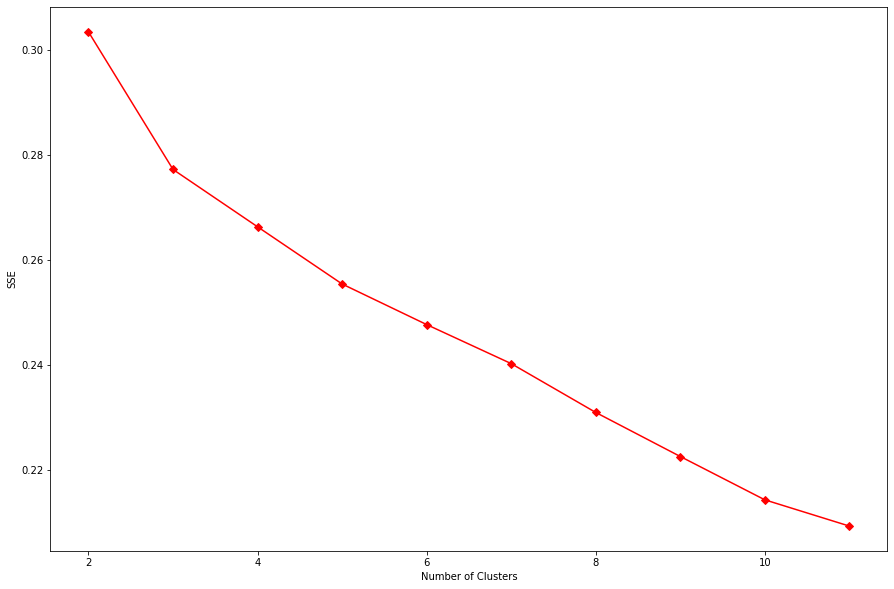

In [17]:
plt.figure(figsize=(15,10))
plt.plot(table.Cluster_Numbers, table.Error_Term, marker = "D", color='red')
plt.xlabel('Number of Clusters')
plt.ylabel('SSE')
plt.show()

* 클러스터 개수가 늘어남에 따라 에러가 줄어드는 것을 확인!
* K-Means 알고리즘에서 최적의 클러스터를 선택하기위해 엘보 방법을 사용. 이는 최적의 k 값을 찾는 것!
* k-means 알고리즘이란?
군집 중심점(centroid)라는 특정한 임의의 지점을 선택해 해당 중심에 가장 가까운 포인트들을 선택하는 군집화기법
선택된 포인트의 평균지점으로 이동하고  이동된 중심점에서 다시 가까운 포인트를 선택, 다시 중심점을 평균 지점으로 이동하는 프로세스를 반복적으로 수행 
* 위에서 엘보방법은 그래프를 보면 SSE 값이 점차 줄다가 어느순간 감소 비율이 급격하게 작아지는 부분이 있는데, 이 부분이 팔꿈치 보양을 닮았다고 해서 엘보라고 함. 즉 이부분을 찾아야 한다!
* 근데 위 그림에서는 엘보를 찾기가 힘듬.. 이런 현상은 클러스터가 잘 정의되어있지 않기 때문. -> 엘보기법의 단점


In [18]:
clusters = KMeans(7)
clusters.fit(final_df)
clusters.labels_

array([6, 6, 6, 3, 6, 0, 3, 3, 4, 2, 2, 6, 6, 0, 2, 6, 1, 6, 6, 6, 1, 2,
       3, 3, 6, 0, 5, 1, 2, 1, 2, 2, 1, 1, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6,
       6, 1, 3, 3, 2, 6, 3, 6, 2, 6, 1, 3, 6, 4, 1, 6], dtype=int32)

* 여기서 종목수를 고려해서 클러스터를 7개로 나눔

In [19]:
labels = clusters.predict(movements)
labels

array([6, 6, 6, 3, 6, 0, 3, 3, 4, 2, 2, 6, 6, 0, 2, 6, 6, 6, 6, 6, 1, 6,
       3, 3, 6, 0, 5, 1, 2, 1, 2, 2, 1, 1, 6, 6, 6, 6, 6, 3, 3, 6, 6, 6,
       2, 1, 3, 3, 2, 6, 3, 6, 2, 6, 1, 3, 6, 4, 1, 6], dtype=int32)

*  위에서 저장한 리스트를 하나ㅢ 데이터 프레임으로 합침

In [20]:
clustered_result = pd.DataFrame({'labels': labels, 'tickers': companies, 'full-name':security, 'sector':sector})
clustered_result.sort_values('labels')

,labels,tickers,full-name,sector
5,0,ATVI,Activision Blizzard,Communication Services
25,0,AMZN,Amazon.com Inc.,Consumer Discretionary
13,0,AKAM,Akamai Technologies Inc,Information Technology
29,1,AEP,American Electric Power,Utilities
45,1,AIV,Apartment Investment & Management,Real Estate
33,1,AWK,American Water Works Company Inc,Utilities
32,1,AMT,American Tower Corp.,Real Estate
58,1,AVB,AvalonBay Communities,Real Estate
27,1,AEE,Ameren Corp,Utilities
54,1,ATO,Atmos Energy,Utilities


* 위에서 보이는 0부터 6까지의 숫자는 하나의 클러스터(군집)을 나타낸다.
* 위 자료를 보면 1 그룹은 거의 it회사들이 많고, 2는 헬스케어, 3은 유틸리티와 부동산이, 4는 금융 회사들이 있는것을 확인 할 수있다. -> 책이랑 나온거랑 좀 다른데 여기서는 IT회사는 3으로 분류됨
* 이 말은 즉 고객의 체류시간, 일평균 구매 금액, 성, 나이 등등의 변수들이 있다고 하면 이 변수들 중 어떤 변수를 통해 군집화 됨을 어느정도 확인 가능.

In [23]:
final_df['Cluster'] = clusters.labels_


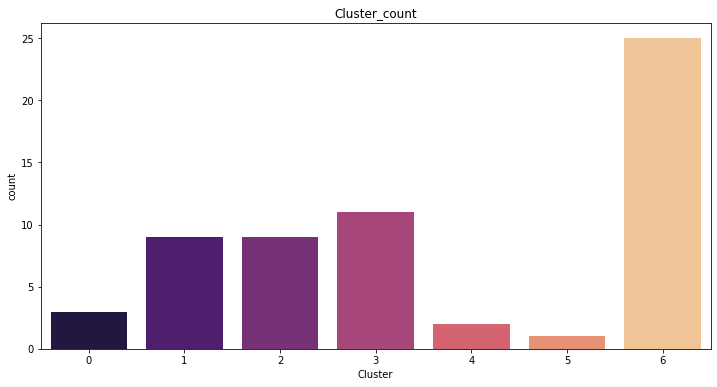

<Figure size 432x288 with 0 Axes>

In [24]:
plt.figure(figsize=(12,6))
sns.countplot(x = 'Cluster', data = final_df, palette = 'magma')
plt.title('Cluster_count')
plt.show()
plt.savefig('cluster_count.png', dpi=300)

* 그래프를 보면 몇개의 종목이 있는지 볼 수있는데, 엑셀보다 파이썬으로하면 사이킷런을 사용하므로 빠르고 쉽게 구현이 가능.